# Tree Model Feature importance : 트리 모델의 변수 중요도


1. Decision Tree
    - Information Gain : 지니 불순도가 감소하는 정도
    - Tree 전체에 대해서, feature별로 Information Gain의 (가중)평균을 계산.
2. Random Forest
    - MDI : Mean Decrease GINI => 지니불순도 감소 평균
    - 개별 트리의 MDI로부터, feature별 Importance 평균 계산
3. XGB
    - weight
        - 모델 전체에서 해당 feature가 split될 때, 사용된 횟수의 합
        - plot_importance에서의 기본값
    - gain
        - feature별 평균 information gain
        - model.feature_importances_의 기본값
        - total_gain : feature별 information gain의 총 합
    - cover
        - feature가 split할 때, 샘플 수의 평균
        - total_cover : 샘플 수의 총 합

# 라이브러리 불러오기

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

# 데이터 로드

In [58]:
data = pd.read_csv('./data/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 산업단지 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사 1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

# 필요한 함수 정의

In [59]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 데이터 준비하기

### 1) x, y로 나누기

In [60]:
target = 'medv'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

### 2) train : validation 분할

In [61]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 20)
x_train.shape

(404, 12)

# Feature Importance

## 1) Decision Tree

##### 라이브러리 불러오기

In [62]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import *

##### 모델 생성

In [63]:
model = DecisionTreeRegressor(max_depth = 3)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

##### 모델 시각화

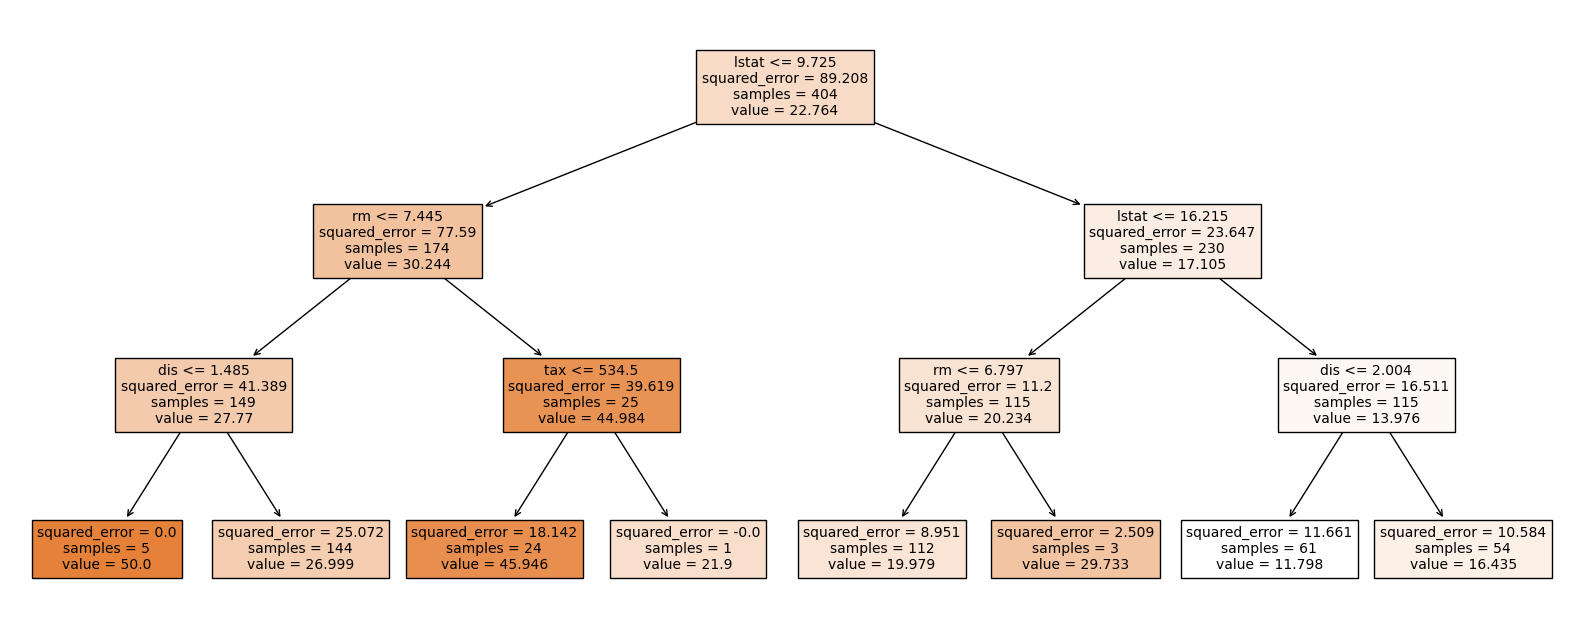

In [64]:
plt.figure(figsize = (20, 8))
plot_tree(model, feature_names = x.columns,
          filled = True, fontsize = 10)
plt.show()

##### 변수 중요도

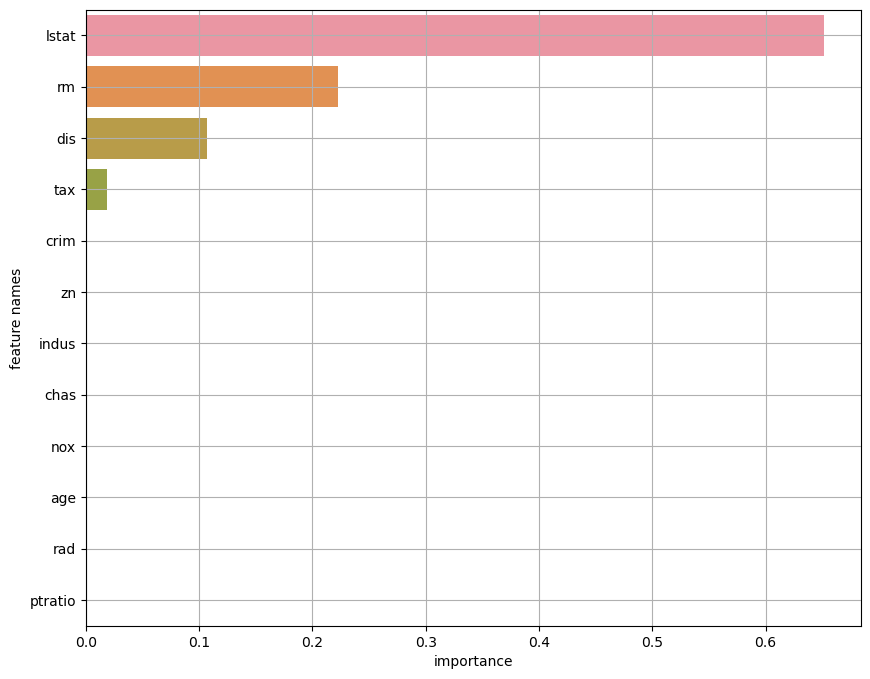

In [65]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [66]:
result

,feature_names,feature_importance
0,lstat,0.651574
1,rm,0.222928
2,dis,0.106809
3,tax,0.018688
4,crim,0.000000
5,zn,0.000000
6,indus,0.000000
7,chas,0.000000
8,nox,0.000000
9,age,0.000000


##### 성능 최적화 이후 변수 중요도 다시 확인

In [67]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':range(1, 10)}
model = DecisionTreeRegressor()
model_gs = GridSearchCV(model, params, cv = 5)
model_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 10)})

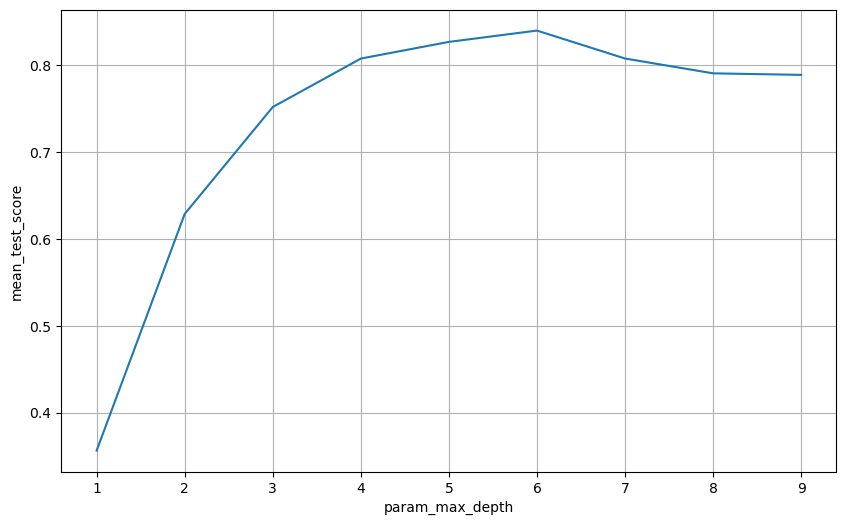

In [68]:
# 튜닝 과정 로그를 df로 저장
result = pd.DataFrame(model_gs.cv_results_)

plt.figure(figsize = (10,6))
sns.lineplot(x='param_max_depth', y='mean_test_score', data = result)
plt.grid()
plt.show()

In [70]:
best_model = model_gs.best_estimator_

In [71]:
best_model

DecisionTreeRegressor(max_depth=6)

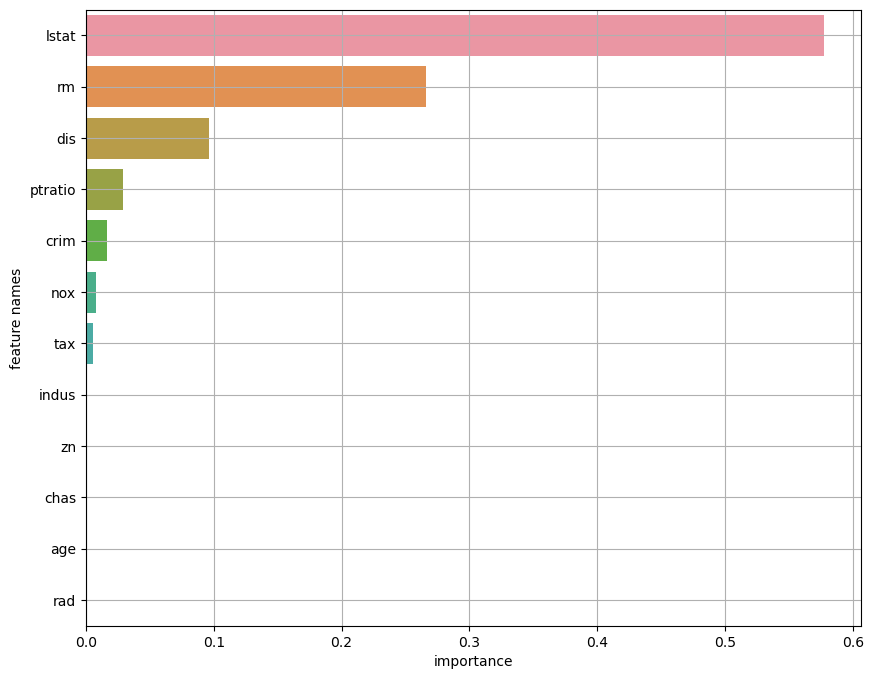

In [72]:
result = plot_feature_importance(best_model.feature_importances_, list(x))

In [73]:
# pred = model_gs.predict(x_val)
pred = best_model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.838713708311812


## 2) Random Forest

##### 라이브러리 불러오기

In [74]:
from sklearn.ensemble import RandomForestRegressor

##### 모델 생성

In [75]:
n_est = 3
model = RandomForestRegressor(n_estimators = n_est, max_depth = 2)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=3)

##### 모델 시각화

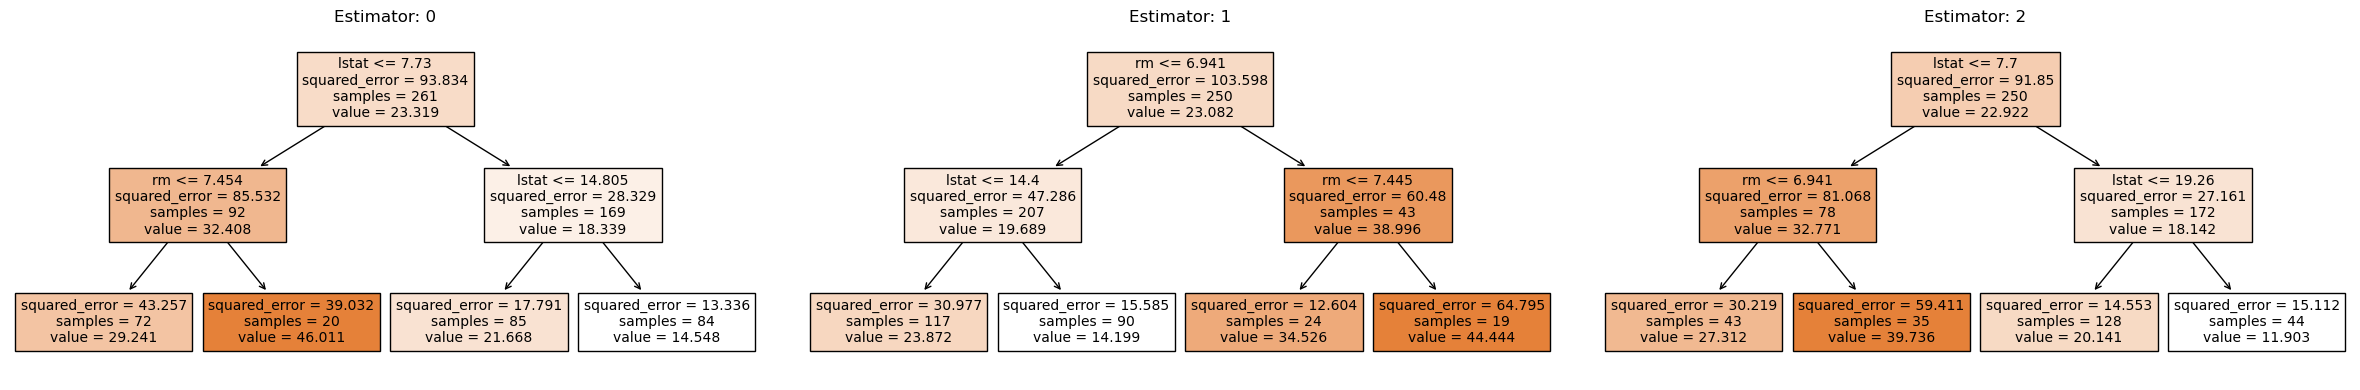

In [76]:
fn=list(x_train)
cn=["0","1"]
fig, axes = plt.subplots(nrows = 1,ncols = n_est,figsize = (24,4))
for index in range(0, n_est):
    plot_tree(model.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True, fontsize = 10,
                   ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 12)

plt.tight_layout()
plt.show()

In [78]:
fi = x_train.iloc[0:0]
for i in range(n_est) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [79]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.222061,0.0,0.0,0.0,0.0,0.0,0.777939
1,0.0,0.0,0.0,0.0,0.0,0.754808,0.0,0.0,0.0,0.0,0.0,0.245192
2,0.0,0.0,0.0,0.0,0.0,0.182970,0.0,0.0,0.0,0.0,0.0,0.817030


In [80]:
fi.mean(axis = 0)

crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
rm         0.386613
age        0.000000
dis        0.000000
rad        0.000000
tax        0.000000
ptratio    0.000000
lstat      0.613387
dtype: float64

In [81]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.0,0.0,0.0,0.0,0.0,0.386613,0.0,0.0,0.0,0.0,0.0,0.613387


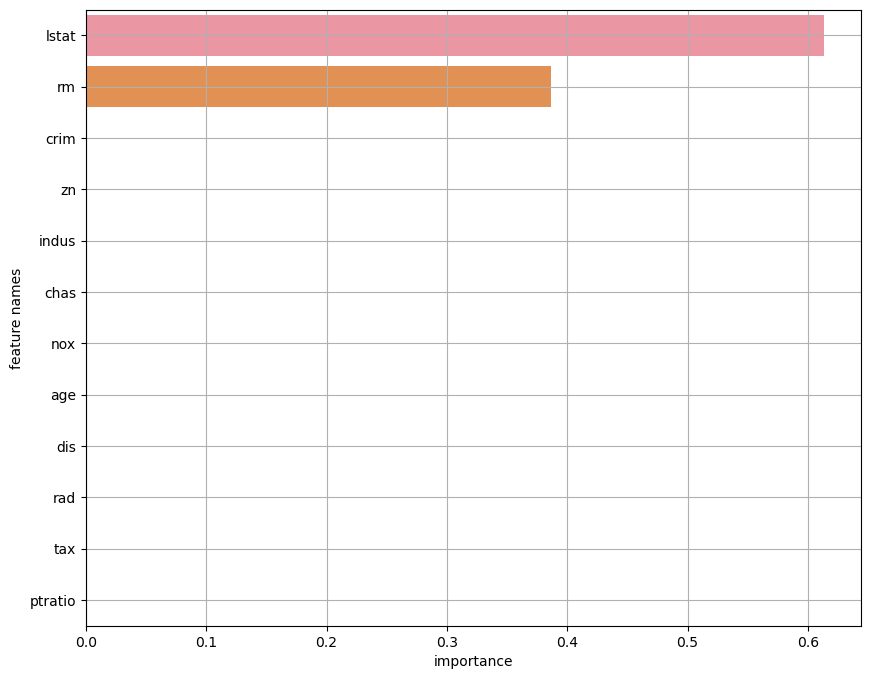

In [82]:
result = plot_feature_importance(model.feature_importances_, list(x))

##### tree = 100개 Random Forest 모델 만들기

In [83]:
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

##### 트리 전체 중요도 저장

In [84]:
fi = x_train.iloc[0:0]
for i in range(100) :
    fi.loc[i] = model.estimators_[i].feature_importances_

In [85]:
fi

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.089113,0.001158,0.002745,0.000066,0.024565,0.265238,0.007740,0.029067,0.000018,0.005035,0.002703,0.572551
1,0.017162,0.001448,0.004152,0.000353,0.008389,0.263492,0.008978,0.162718,0.000224,0.007721,0.010187,0.515177
2,0.009406,0.000059,0.010109,0.000001,0.030288,0.104501,0.009683,0.041361,0.000401,0.012169,0.014226,0.767797
3,0.048692,0.000585,0.005206,0.000079,0.029539,0.243536,0.013051,0.036420,0.000493,0.007121,0.009982,0.605297
4,0.026516,0.003936,0.002766,0.003262,0.030543,0.226098,0.010681,0.083406,0.000708,0.007539,0.009275,0.595271
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.100746,0.000382,0.016320,0.000611,0.013099,0.229906,0.005760,0.008479,0.029143,0.000616,0.003104,0.591835
96,0.019008,0.000278,0.011358,0.000218,0.024296,0.632826,0.012944,0.102478,0.000015,0.007291,0.012823,0.176465
97,0.094627,0.002298,0.004892,0.000832,0.004878,0.280872,0.008896,0.059924,0.002139,0.012882,0.008191,0.519570
98,0.019863,0.002005,0.004206,0.000592,0.016576,0.628594,0.004419,0.050614,0.006382,0.030437,0.009748,0.226562


##### 트리 100개의 평균 중요도

In [86]:
fi.mean(axis = 0)

crim       0.041414
zn         0.001292
indus      0.004973
chas       0.000905
nox        0.021413
rm         0.368747
age        0.013019
dis        0.068522
rad        0.003922
tax        0.011290
ptratio    0.015206
lstat      0.449296
dtype: float64

In [87]:
fi_rf = {}

for i, v in enumerate(list(x)) :
    fi_rf[v] = model.feature_importances_[i]

pd.DataFrame(fi_rf, index = [0])

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.041414,0.001292,0.004973,0.000905,0.021413,0.368747,0.013019,0.068522,0.003922,0.01129,0.015206,0.449296


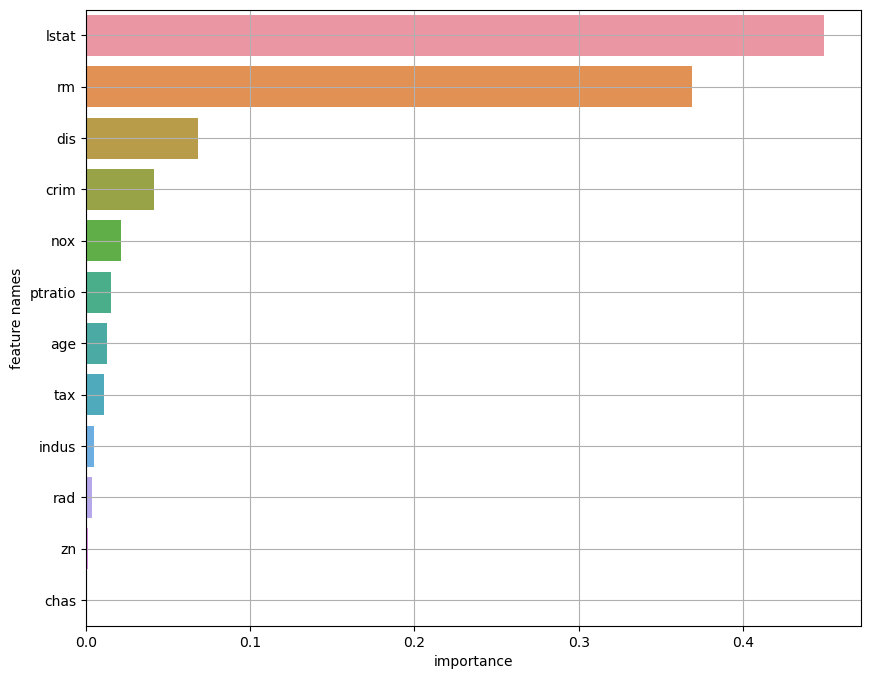

In [88]:
result = plot_feature_importance(model.feature_importances_, list(x))

In [89]:
pred = model.predict(x_val)
print(mean_absolute_error(y_val, pred))

2.4229215686274492


## 3) XGB

##### 라이브러리 불러오기

In [90]:
from xgboost import XGBRegressor, plot_tree, plot_importance

##### 모델 생성

In [91]:
model = XGBRegressor(n_estimators = 10, max_depth = 2, objective='reg:squarederror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

##### 모델 시각화

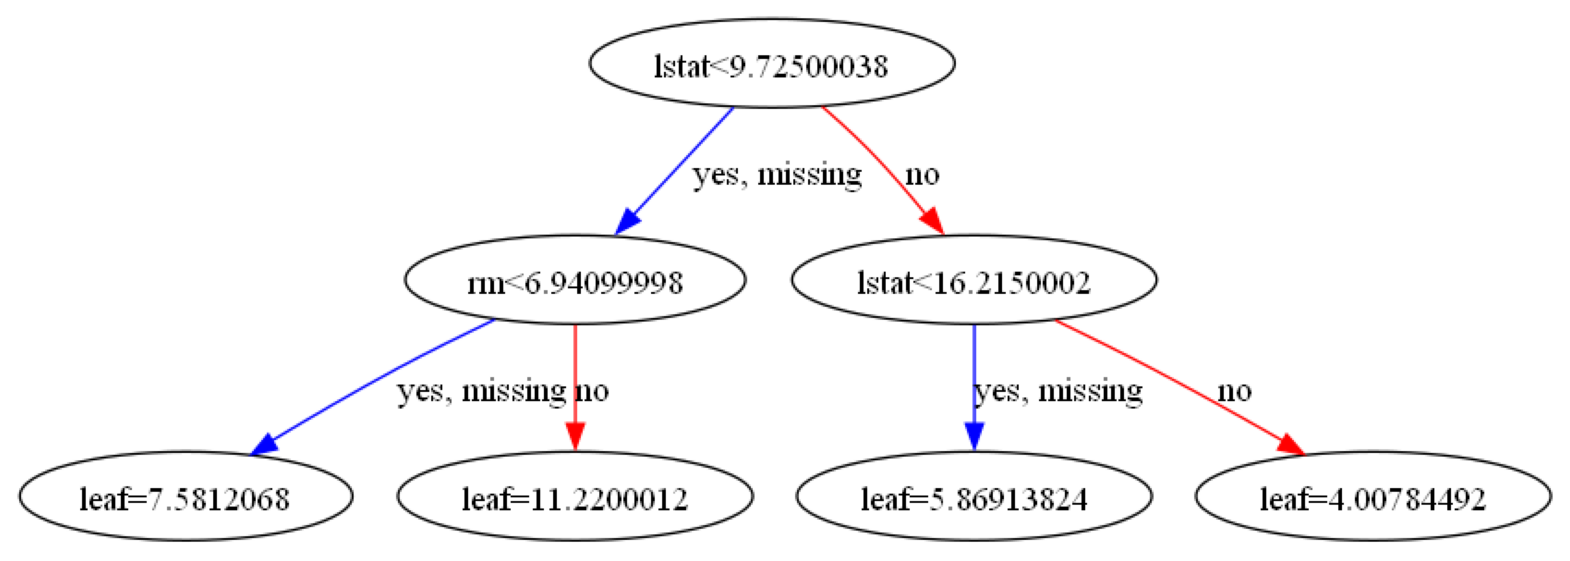

In [92]:
plt.rcParams['figure.figsize'] = 20,20
plot_tree(model)
plt.show()

* leaf 노드의 값 ==> 로지스틱 함수에 넣으면 0~1 사이의 값으로 변환됨.
* 몇가지 옵션
    * num_trees = 0
    * rankdir='LR'

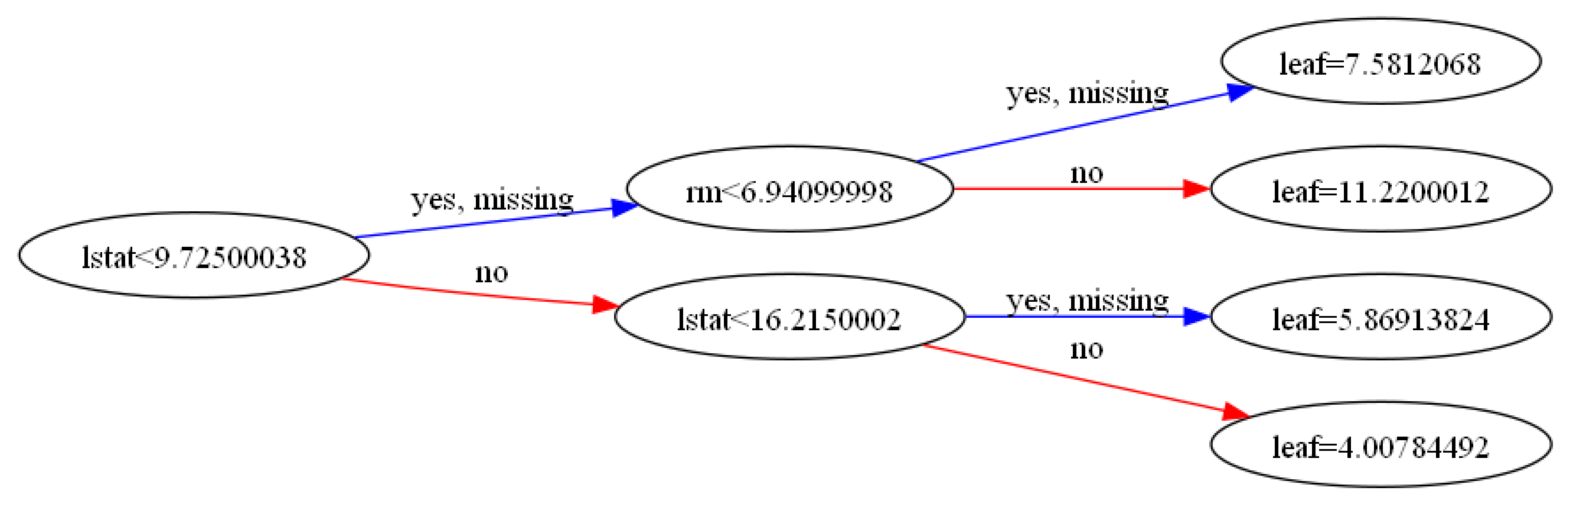

In [93]:
plot_tree(model, num_trees = 0, rankdir = 'LR')
plt.show()

* plot_importance
    * 변수중요도 기본값은 weight

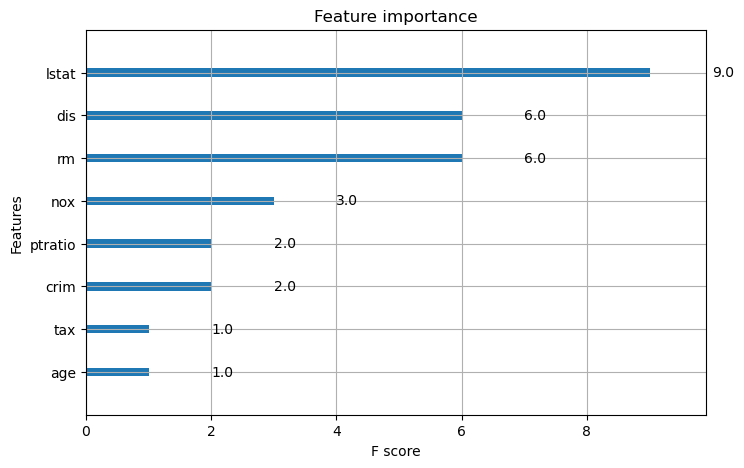

In [94]:
plt.rcParams['figure.figsize'] = 8, 5
plot_importance(model)
plt.show()

* model.feature_importances_ : 변수중요도 기본값은 gain.

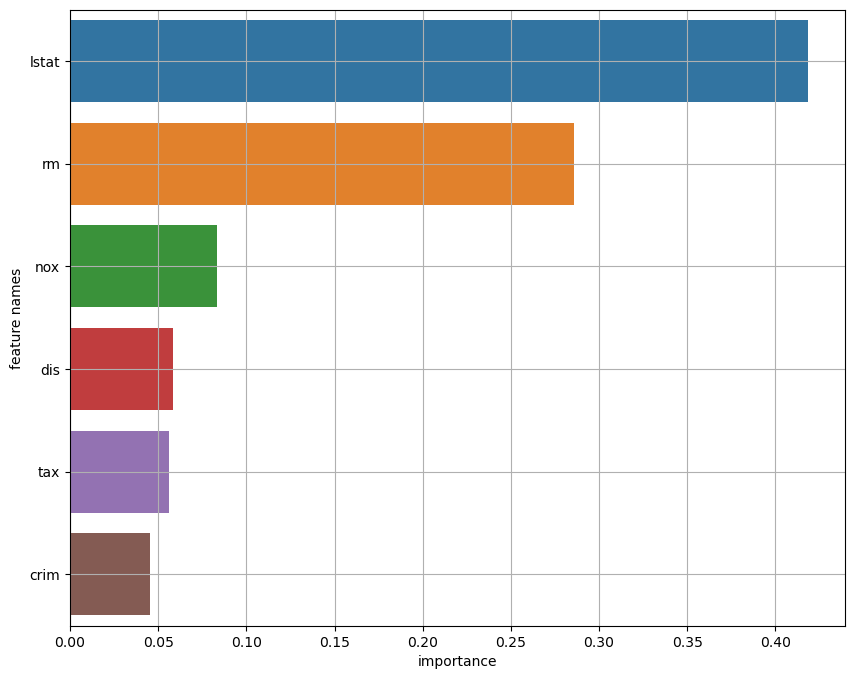

In [95]:
result = plot_feature_importance(model.feature_importances_, list(x),6)

* xgb의 변수 중요도
    * weight : 모델 전체에서 해당 feature가 split될 때 사용된 횟수의 합(plot_tree 에서의 기본값)
    * gain : feature별 평균 imformation gain.(model.feature_importances_ 의 기본값)
    * cover : feature가 split 할때의 샘플 수의 평균.

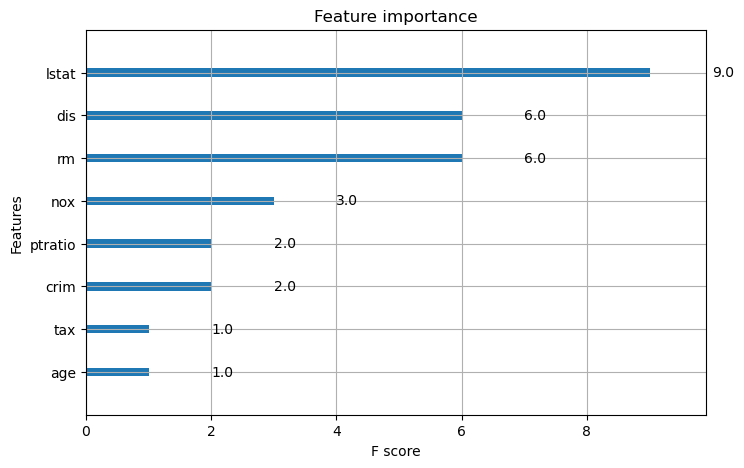

In [96]:
# importance_type='weight'
plot_importance(model)
plt.show()

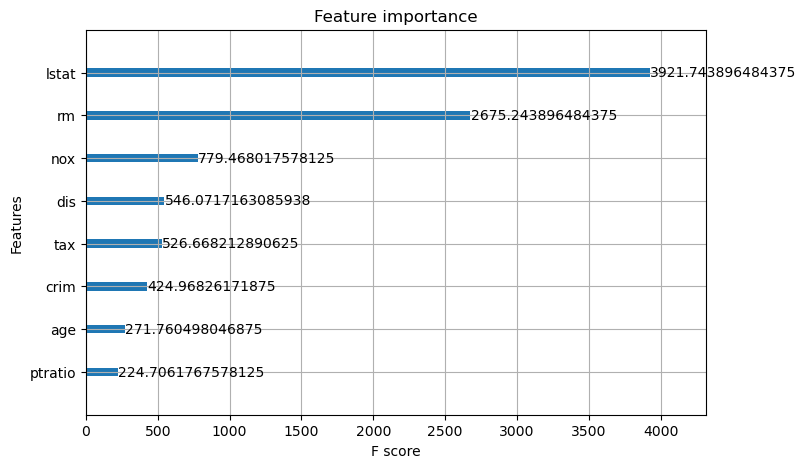

In [97]:
# importance_type='gain'
plot_importance(model, importance_type='gain')
plt.show()

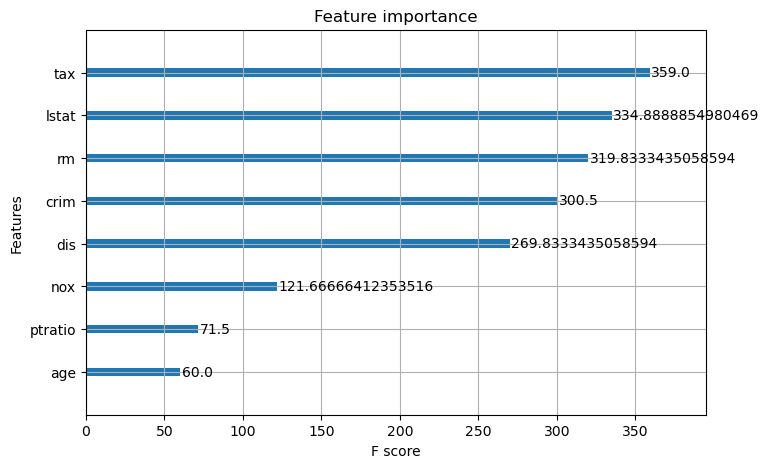

In [98]:
# importance_type='cover'
plot_importance(model, importance_type='cover')
plt.show()